# CADEC 데이터를 훈련시켜 NER 기반의 약물 탐지 모델 만들기


In [ ]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-58dgi6ar
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-58dgi6ar


In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
f = open('/content/drive/My Drive/test.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="	":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue

    splits = line.split('	') 
    
    splits[-1] = re.sub(r'\n', '', splits[-1]) 
    word = splits[0].lower()
    sentence.append([word, splits[-1]])

print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  7593


샘플의 최대 길이 : 236
샘플의 평균 길이 : 16.016199


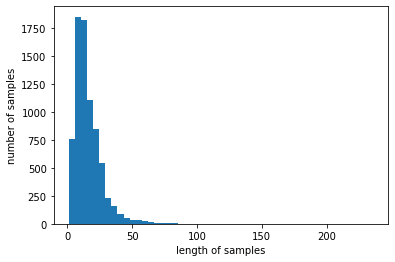

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: 
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) 
    ner_tags.append(list(tag_info)) 
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') 
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) 
tar_tokenizer.fit_on_texts(ner_tags)
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)


단어 집합의 크기 : 6757
개체명 태깅 정보 집합의 크기 : 4


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
decoded = []
for index in X_train[0] : 
    decoded.append(index_to_word[index])

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))


기존의 문장 : ['pain', 'in', 'my', 'left', 'leg', 'and', 'most', 'of', 'my', 'joints', '.']
디코딩 문장 : ['pain', 'in', 'my', 'left', 'leg', 'and', 'most', 'of', 'my', 'joints', '.']


In [ ]:
max_len = 70
max_len_char = 10

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.3, random_state=777)
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)
print(len(X_test))

2278


In [ ]:
from tensorflow.keras.callbacks import Callback
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): 
      result = []
      for sequence in sequences: 
          tag = []
          for pred in sequence: 
              pred_index = np.argmax(pred) 
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) 
          result.append(tag)
      return result

 
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('/content/drive/My Drive/best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-u1388bgx
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-u1388bgx


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from pathlib import Path
from keras.initializers import Constant
from keras.layers import SpatialDropout1D
import os

In [ ]:


embeddings_index = {}
f = open(os.path.join('/content/drive/My Drive/glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1210 word vectors.


In [ ]:
from keras.preprocessing.text import Tokenizer
word_index = src_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

num_words = min(max_len, len(word_index)) + 1
print(num_words)

embedding_dim = 300

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_len:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

Found 6756 unique tokens.
71


In [ ]:
from sklearn.utils import class_weight, compute_sample_weight,compute_class_weight
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.utils import class_weight, compute_sample_weight,compute_class_weight
class_weights = np.zeros((70, 4))
class_weights[:, 0] +=  0.383408827
class_weights[:, 1] += 1
class_weights[:, 2] += 6.829094379877604
class_weights[:, 3] += 4.0752169397259355
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,embeddings_initializer=Constant(embedding_matrix),input_length=max_len, mask_zero=True,trainable=True))

#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5)))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(100, activation="relu")))
#model.add(Dropout(0.52))
crf = CRF(tag_size)
model.add(crf)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4) 
adam =Adam(lr=0.001,decay=0.9)
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
#history = model.fit(X_train, y_train, batch_size = 128, epochs = 25, validation_split = 0.1, verbose = 1, callbacks=[F1score(use_char=False)])
model.summary()
#history = model.fit(X_train, y_train, batch_size=20, epochs=200,validation_split=0.1, verbose=2,class_weight=class_weights)
history = model.fit(X_train, y_train, batch_size=20, epochs=200,validation_split=0.1, verbose=2,callbacks = [es],class_weight=class_weights)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           2027100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 200)           320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 100)           20100     
_________________________________________________________________
crf_1 (CRF)                  (None, 70, 4)             428       
Total params: 2,368,428
Trainable params: 2,368,428
Non-trainable params: 0
_________________________________________________________________

Train on 4783 samples, validate on 532 samples
Epoch 1/200
 - 92s - loss: 8.5049 - crf_viterbi_accuracy: 0.8863 - val_loss: 8.6216 

In [ ]:
!pip install sklearn-crfsuite
from sklearn.metrics import classification_report,f1_score
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag


report = flat_classification_report(y_pred=pred_tags, y_true=test_tags)
print(report)

     |████████████████████████████████| 743 kB 11.0 MB/s 
              precision    recall  f1-score   support

       B-ADR       0.74      0.73      0.73      1763
       I-ADR       0.59      0.74      0.66      2904
           O       0.99      0.99      0.99    154793

    accuracy                           0.98    159460
   macro avg       0.78      0.82      0.79    159460
weighted avg       0.98      0.98      0.98    159460



# celecoxib, ibuprofen, naproxen의 부정 리뷰를 모델에 적용해 약물 부작용 표현 추출 

In [ ]:
f = open('/content/drive/My Drive/0802naproxen_neg.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="	":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue

    splits = line.split('	') 
    
    splits[-1] = re.sub(r'\n', '', splits[-1]) 
    word = splits[0].lower() 
    sentence.append([word, splits[-1]]) 

print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  1289


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: 
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) 
    ner_tags.append(list(tag_info)) 

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') 
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

decoded = []
for index in X_train[0] : 
    decoded.append(index_to_word[index]) 


max_len = 70

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)


y_train = to_categorical(y_train, num_classes=tag_size)

단어 집합의 크기 : 2423
개체명 태깅 정보 집합의 크기 : 4


In [ ]:
i=3 
y_predicted =model.predict(np.array([X_train[i]])) 
y_predicted = np.argmax(y_predicted, axis=-1) 
true = np.argmax(y_train[i], -1) 

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_train[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
i                : O       O
took             : O       O
the              : O       O
naproxen         : O       O
after            : O       O
eating           : O       O
some             : O       I-ADR
food             : O       O
,                : O       O
but              : O       O
i                : O       O
was              : O       O
waiting          : O       O
hours            : O       O
and              : O       O
nothing          : O       O
happened         : O       O
.                : O       O


In [ ]:
import openpyxl

  
wb = openpyxl.Workbook()

sheet = wb.active
sheet.append(["Word","Pred"])

for i in range(X_train.shape[0]):
  y_predicted =model.predict(np.array([X_train[i]]))
  y_predicted = np.argmax(y_predicted, axis=-1) 
  true = np.argmax(y_train[i], -1)


# Visualization
  #print("Sample number {} of {} (Test Set)".format(i, X.shape[0]))
# Visualization
  #print("{:15}||{:5}||{}".format("Word", "Pred", "t"))
  #print(30 * "=")
  for w, t, pred in zip(X_train[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        #print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
        sheet.append([index_to_word[w],index_to_ner[pred]])
wb.save("na_pred.xlsx")